In [1]:
import tensornetwork as tn
import ocr_data

import numpy as np

In [2]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = [10,7]
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['ytick.right'] = True
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['ytick.minor.visible'] = True
matplotlib.rcParams['font.size'] = 19
matplotlib.rcParams['font.family'] = 'DejaVu Serif'
matplotlib.rcParams['mathtext.default'] = 'regular'
matplotlib.rcParams['errorbar.capsize'] = 3

In [3]:
input_shape = ocr_data.in_2d_shape
conv_kernels = [] #[(5,5)] #[(3,3),(3,3),(3,3),(3,3),(3,3)]
conv_stride = [] #[(3,3)] #[(1,1),(2,2),(1,1),(2,2),(1,1)]
conv_outs = [] #[(4,)] #[(4,),(8,),(8,),(16,),(16,)]
conv_layers = len(conv_kernels)
hidden_shapes = [(10,10)]
hidden_layers = len(hidden_shapes)
residual_layers = 5
more_hidden_shapes = [(10,10)]
more_hidden_layers = len(hidden_shapes)
output_shape = ocr_data.out_shape
print(input_shape,output_shape)

(32, 32) (26,)


In [4]:
in_layer = tn.Input(input_shape)()
last_layer = in_layer
print(in_layer)
for kernel_shape,out_shape,kernel_stride in zip(conv_kernels,conv_outs,conv_stride):
    last_layer = tn.Conv(kernel_shape,out_shape=out_shape,kernel_stride=kernel_stride,pad=True,activation=tn.ReLU())(last_layer)
    print(last_layer)
for hidden_shape in hidden_shapes:
    last_layer = tn.Dense(hidden_shape,activation=tn.ReLU())(last_layer)
    print(last_layer)
for i in range(residual_layers):
    last_layer = tn.ResWrap(tn.Dense(last_layer.output_shapes[0],activation=tn.ReLU()))(last_layer)
    print(last_layer)
for hidden_shape in more_hidden_shapes:
    last_layer = tn.Dense(hidden_shape,activation=tn.Tanh())(last_layer)
    print(last_layer)
out_layer = tn.Dense(output_shape,activation=tn.Sigmoid())(last_layer)
print(out_layer)

s = tn.System(inputs=[in_layer],outputs=[out_layer])

Input :: [] -> [(32, 32)]
Dense :: [(32, 32)] -> [(10, 10)]
ResWrap :: [(10, 10)] -> [(10, 10)]
ResWrap :: [(10, 10)] -> [(10, 10)]
ResWrap :: [(10, 10)] -> [(10, 10)]
ResWrap :: [(10, 10)] -> [(10, 10)]
ResWrap :: [(10, 10)] -> [(10, 10)]
Dense :: [(10, 10)] -> [(10, 10)]
Dense :: [(10, 10)] -> [(26,)]
Dense :: [(10, 10)] -> [(10, 10)] idx: 1 => Dense :: [(10, 10)] -> [(26,)] idx: 0
ResWrap :: [(10, 10)] -> [(10, 10)] idx: 2 => Dense :: [(10, 10)] -> [(10, 10)] idx: 1
Add :: [(10, 10), (10, 10)] -> [(10, 10)] idx: 3 => ResWrap :: [(10, 10)] -> [(10, 10)] idx: 2
ResWrap :: [(10, 10)] -> [(10, 10)] idx: 4 => Add :: [(10, 10), (10, 10)] -> [(10, 10)] idx: 3
Dense :: [(10, 10)] -> [(10, 10)] idx: 5 => Add :: [(10, 10), (10, 10)] -> [(10, 10)] idx: 3
Add :: [(10, 10), (10, 10)] -> [(10, 10)] idx: 6 => ResWrap :: [(10, 10)] -> [(10, 10)] idx: 4
Dense :: [(10, 10)] -> [(10, 10)] idx: 7 => Dense :: [(10, 10)] -> [(10, 10)] idx: 5
ResWrap :: [(10, 10)] -> [(10, 10)] idx: 8 => Add :: [(10, 10),

In [5]:
import multiprocessing
import functools

def batch(length=1000):    
    total,failures = 0,0
    state = None
    for true_out,input in ocr_data.tagged_2d_data(length):
        guess_out,state = s.guess([input],return_state=True)
        #print(guess_out[0]-true_out)
        if np.argmax(guess_out[0]) != np.argmax(true_out):
            failures += 1
        s.learn(state,[true_out],scale=1e-2,loss='quad')
        total += 1
    return total,failures

In [6]:
print('loading weights')
#s.load_weights('OCR_residual_network.h5')

loading weights


In [7]:
%prun batch(100)

In [8]:
try:
    batch_size = 10000
    while True:
        cases,failures = batch(batch_size)
        print('saving weights')
        s.save_weights('OCR_residual_network.h5')
        print('batch accuracy',cases-failures,'/',cases)
        if (cases-failures)/cases > 0.99:
            break
except KeyboardInterrupt:
    print('Stopped by user')

saving weights
batch accuracy 2556 / 10000
saving weights
batch accuracy 4235 / 10000
saving weights
batch accuracy 5479 / 10000
saving weights
batch accuracy 6065 / 10000
saving weights
batch accuracy 6473 / 10000
saving weights
batch accuracy 6737 / 10000
saving weights
batch accuracy 6917 / 10000
saving weights
batch accuracy 7217 / 10000
saving weights
batch accuracy 7291 / 10000
saving weights
batch accuracy 7461 / 10000
saving weights
batch accuracy 7489 / 10000
saving weights
batch accuracy 7598 / 10000
saving weights
batch accuracy 7849 / 10000
saving weights
batch accuracy 7826 / 10000
saving weights
batch accuracy 7965 / 10000
saving weights
batch accuracy 7995 / 10000
saving weights
batch accuracy 8013 / 10000
saving weights
batch accuracy 8022 / 10000
saving weights
batch accuracy 8058 / 10000
saving weights
batch accuracy 8205 / 10000
saving weights
batch accuracy 8245 / 10000
saving weights
batch accuracy 8225 / 10000
saving weights
batch accuracy 8303 / 10000
saving weig

neuron A


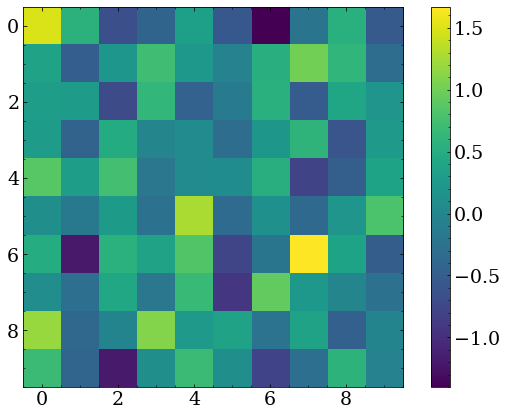

neuron B


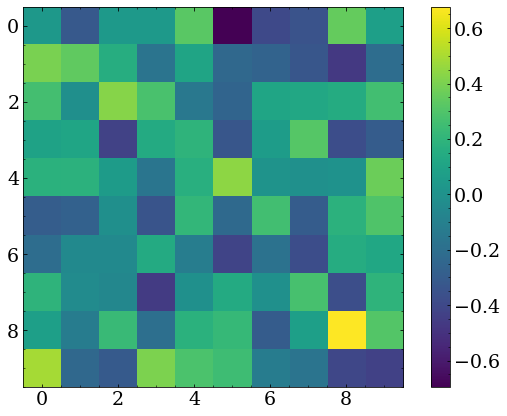

neuron C


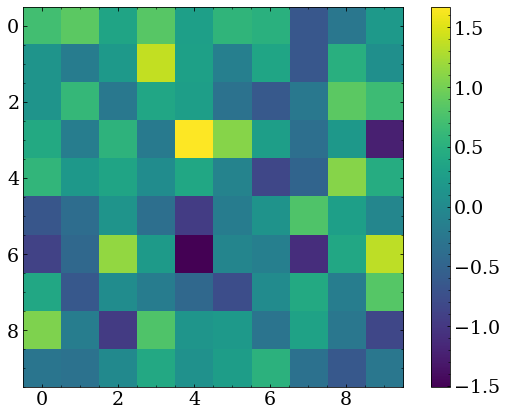

neuron D


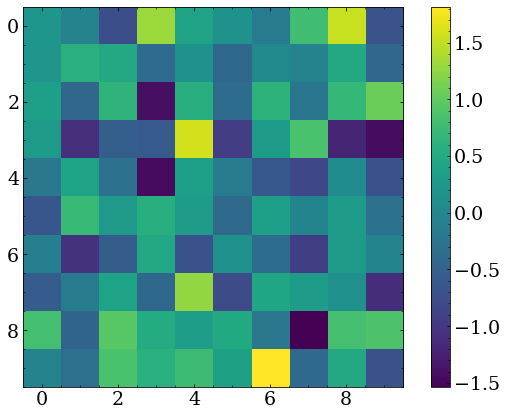

neuron E


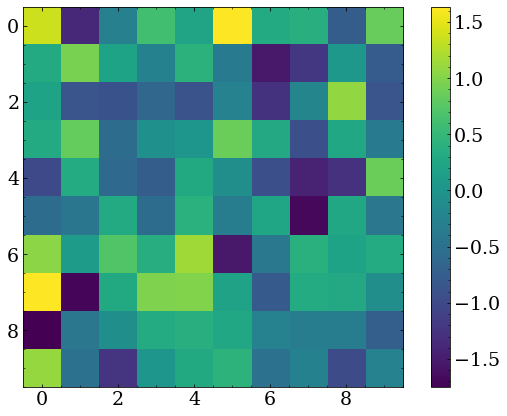

neuron F


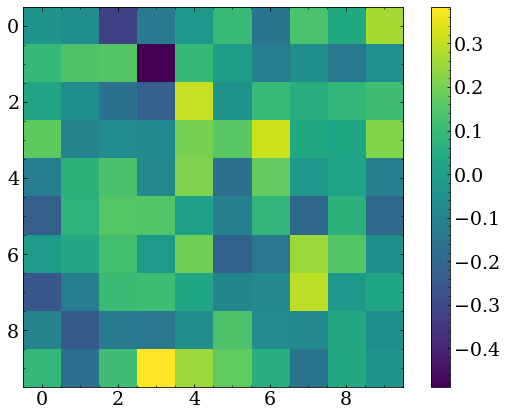

neuron G


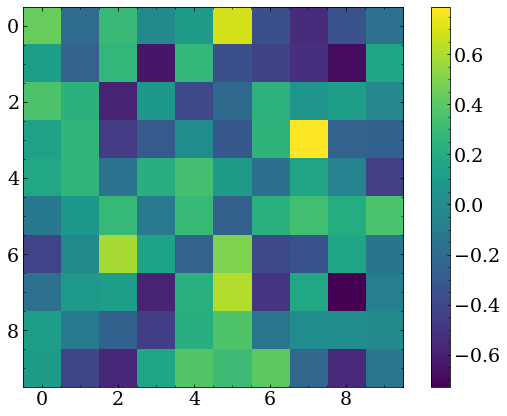

neuron H


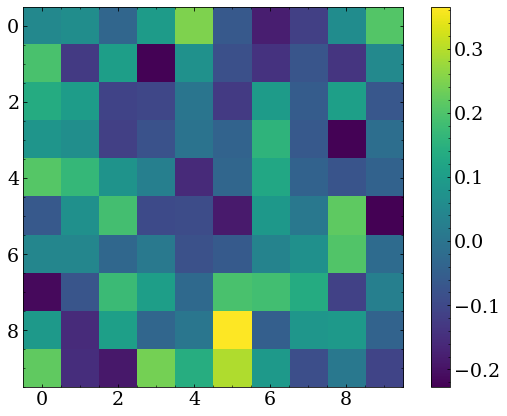

neuron I


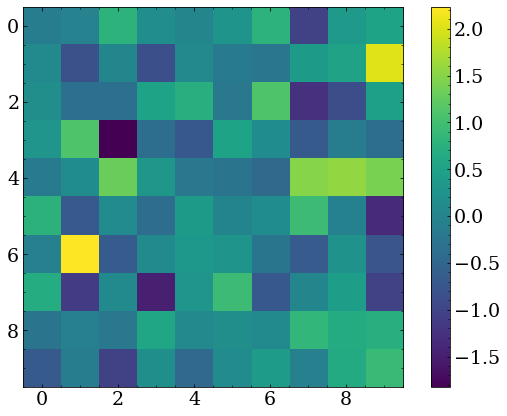

neuron J


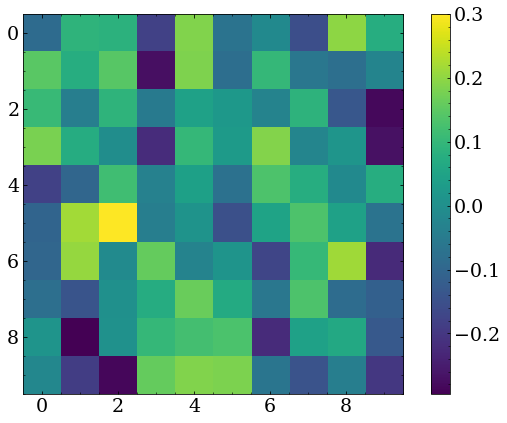

neuron K


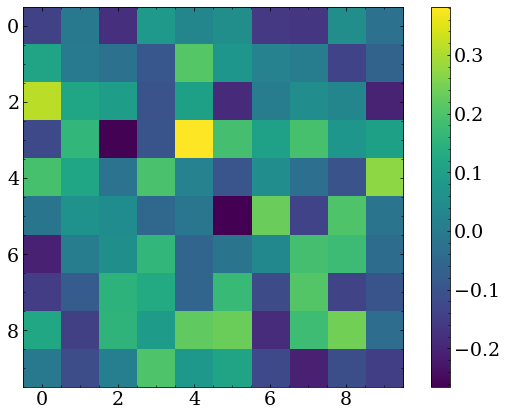

neuron L


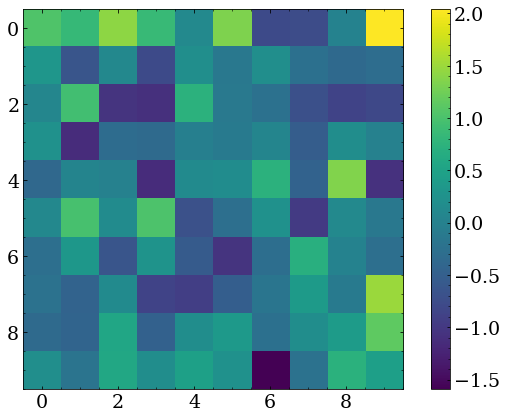

neuron M


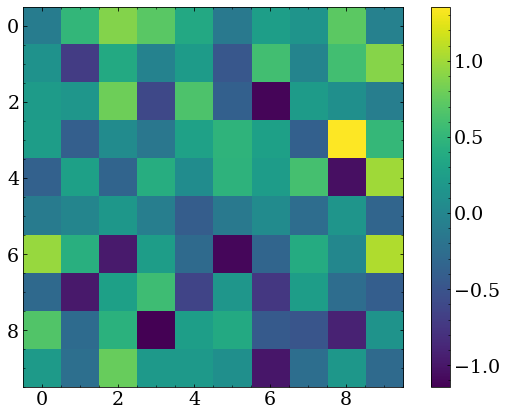

neuron N


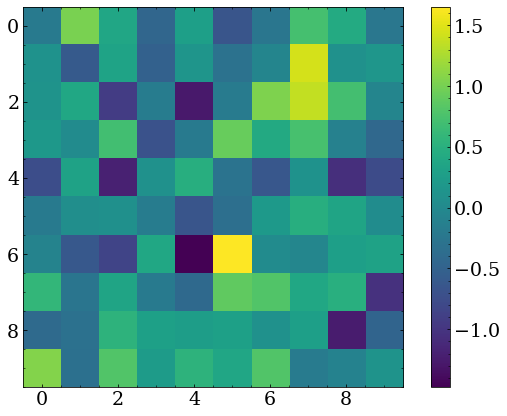

neuron O


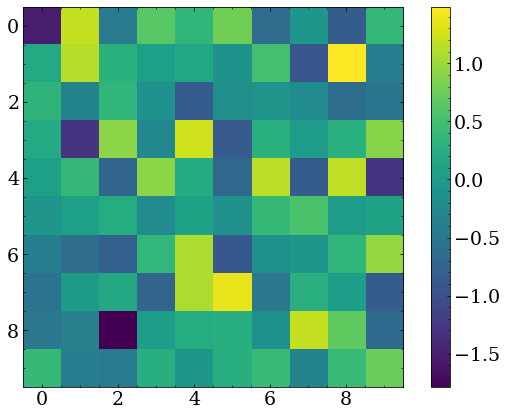

neuron P


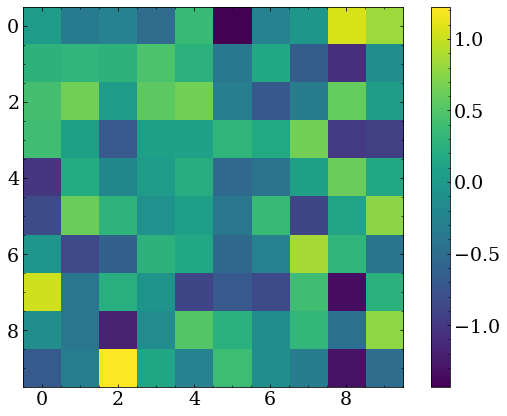

neuron Q


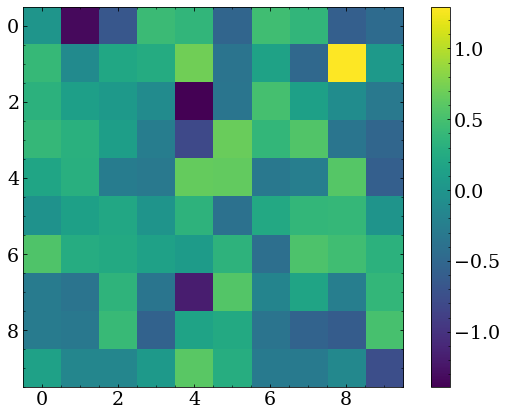

neuron R


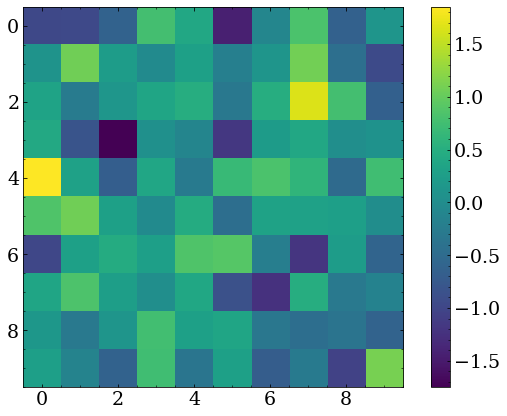

neuron S


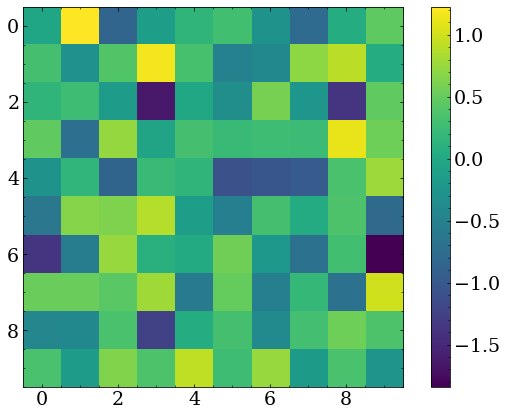

neuron T


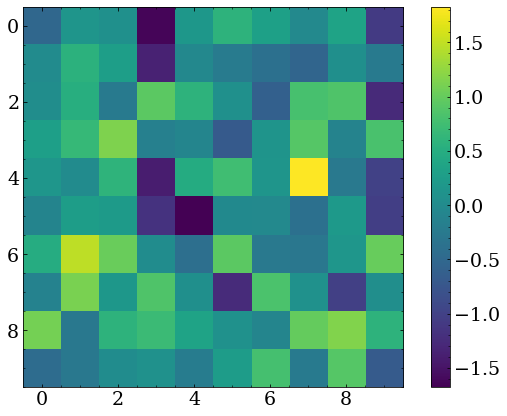

neuron U


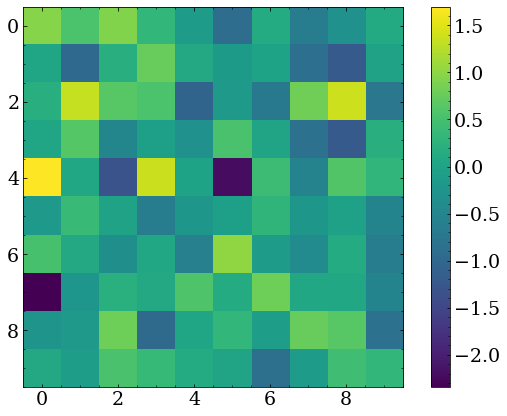

neuron V


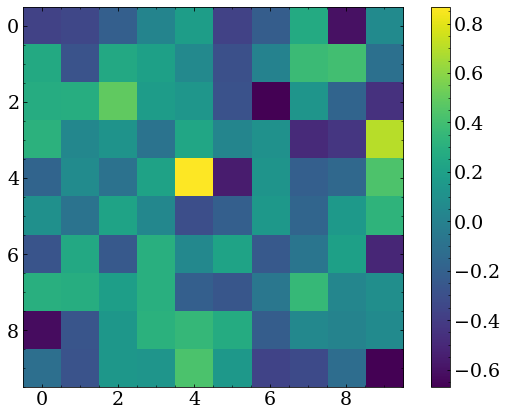

neuron W


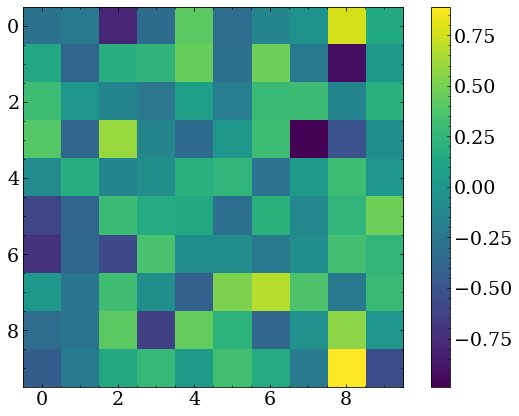

neuron X


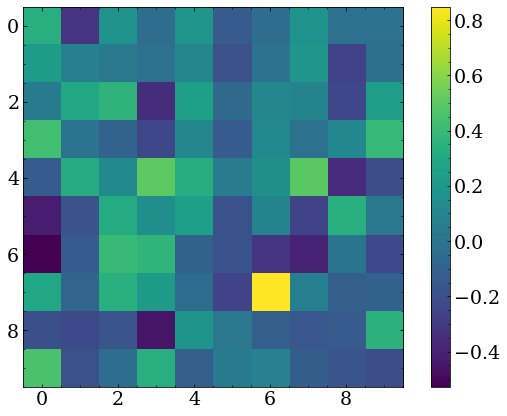

neuron Y


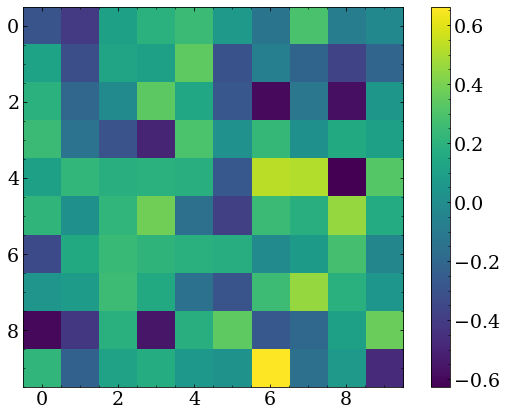

In [9]:
for i,c in enumerate(range(ord('A'),ord('Z'))):
    print('neuron',chr(c))
    plt.imshow(s.parts[0].layer[0].weights[i,:].reshape(hidden_shapes[-1]))
    plt.colorbar()
    plt.show()
    plt.close()

Dense :: [(32, 32)] -> [(10, 10)]
layer -4 neuron 0


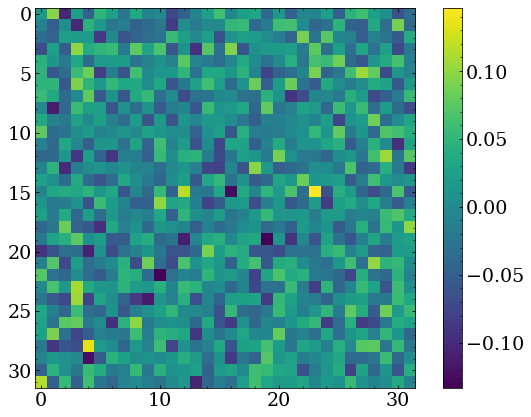

layer -4 neuron 1


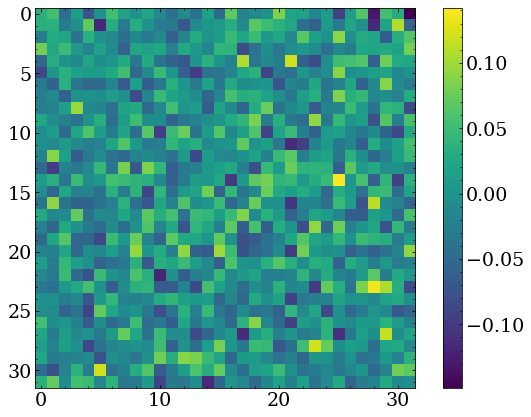

layer -4 neuron 2


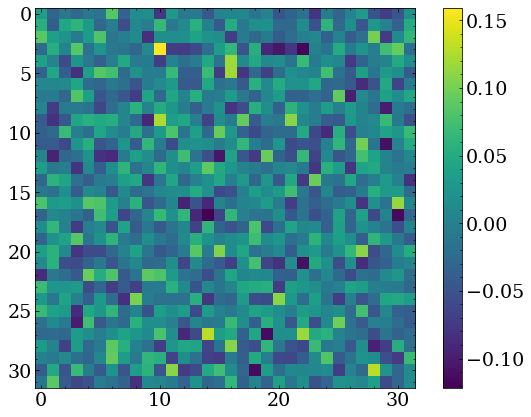

layer -4 neuron 3


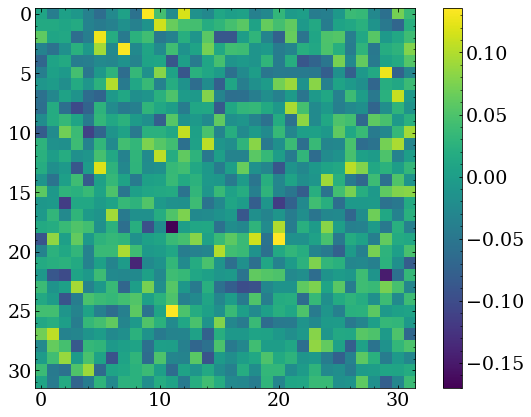

layer -4 neuron 4


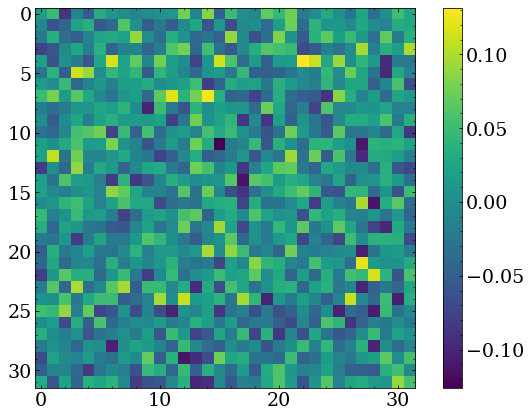

layer -4 neuron 5


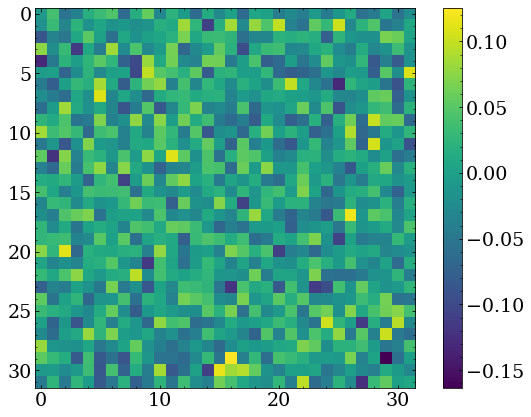

layer -4 neuron 6


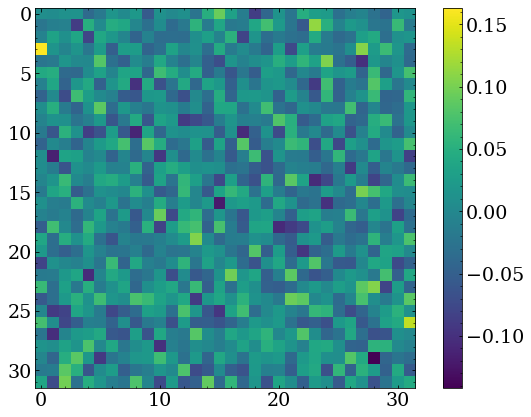

layer -4 neuron 7


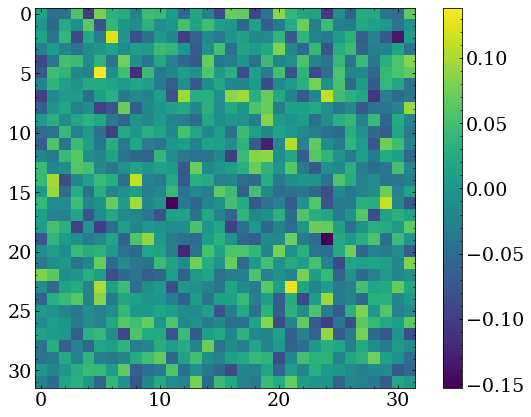

layer -4 neuron 8


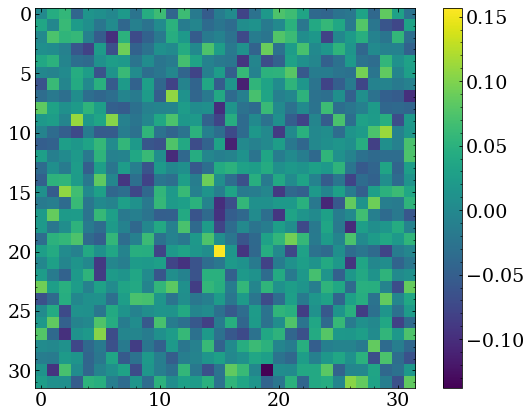

layer -4 neuron 9


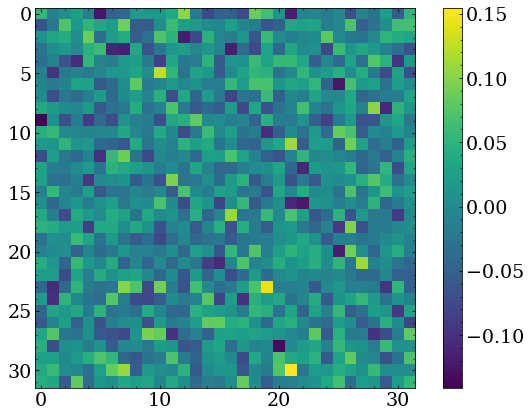

layer -4 neuron 10


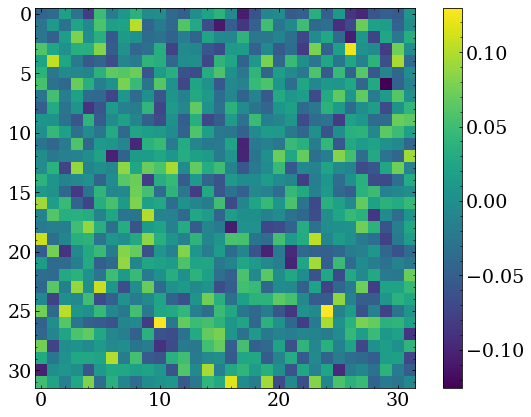

layer -4 neuron 11


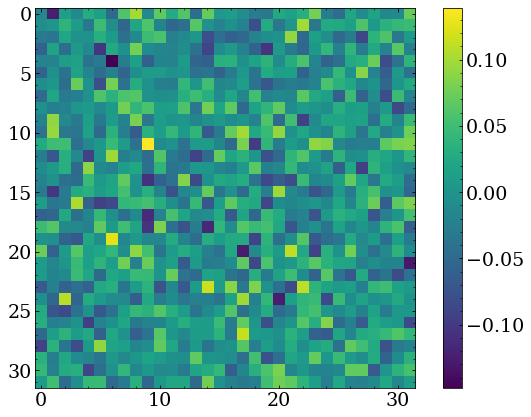

layer -4 neuron 12


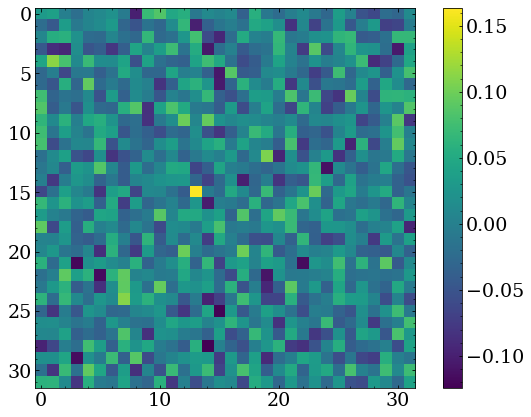

layer -4 neuron 13


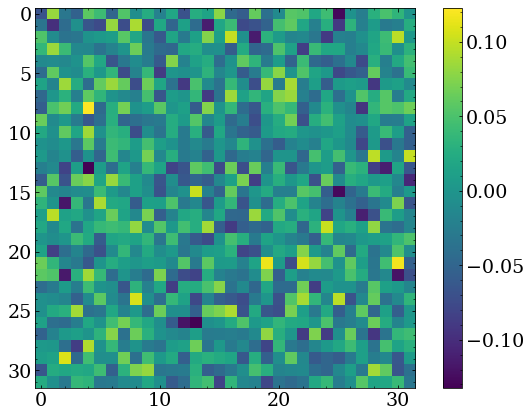

layer -4 neuron 14


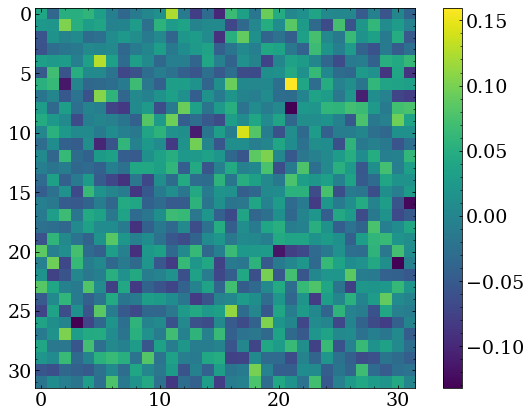

layer -4 neuron 15


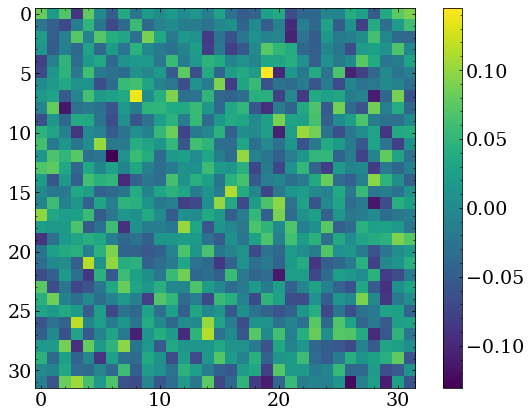

layer -4 neuron 16


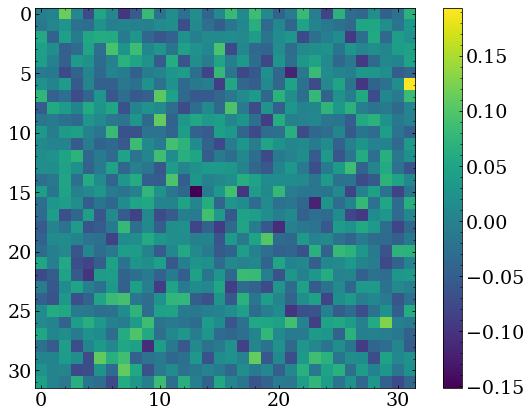

layer -4 neuron 17


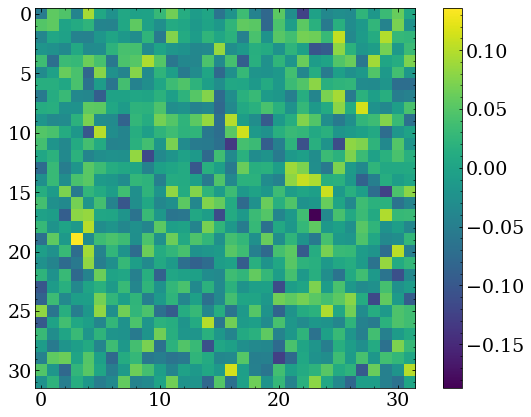

layer -4 neuron 18


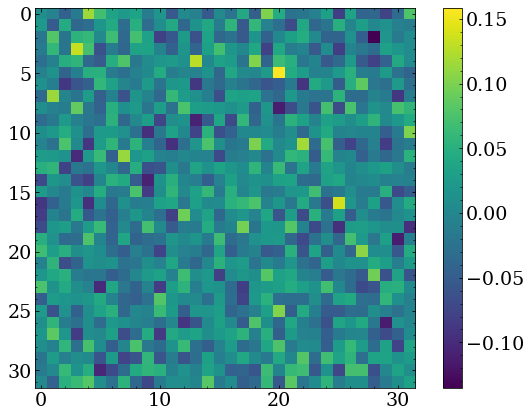

layer -4 neuron 19


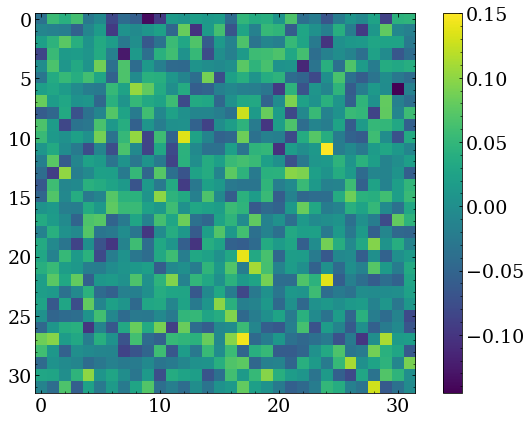

layer -4 neuron 20


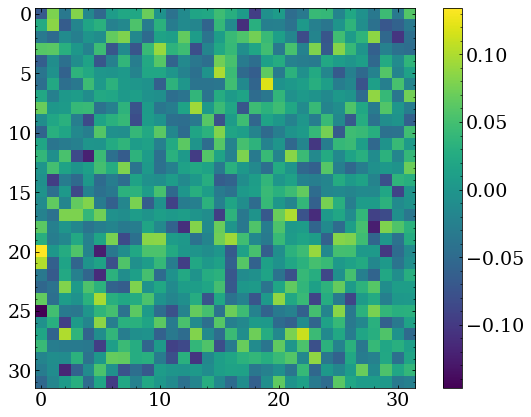

layer -4 neuron 21


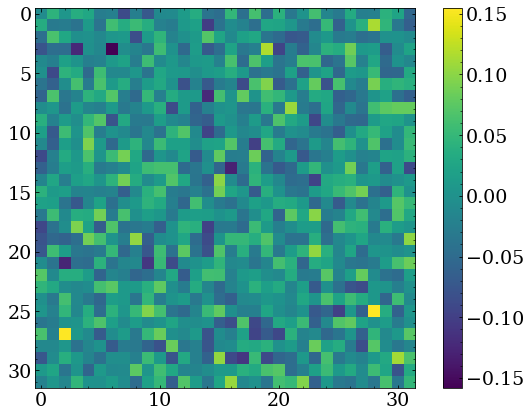

layer -4 neuron 22


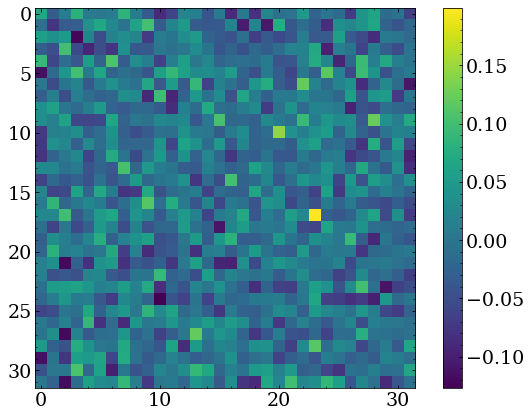

layer -4 neuron 23


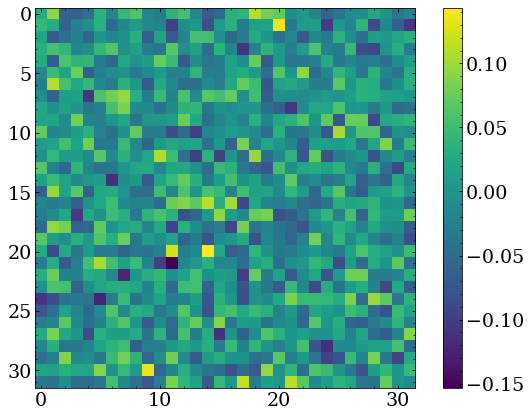

layer -4 neuron 24


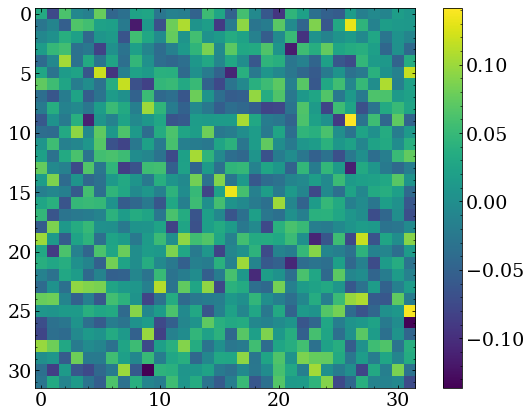

layer -4 neuron 25


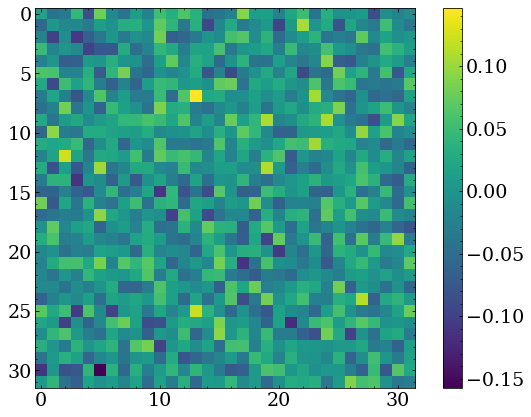

layer -4 neuron 26


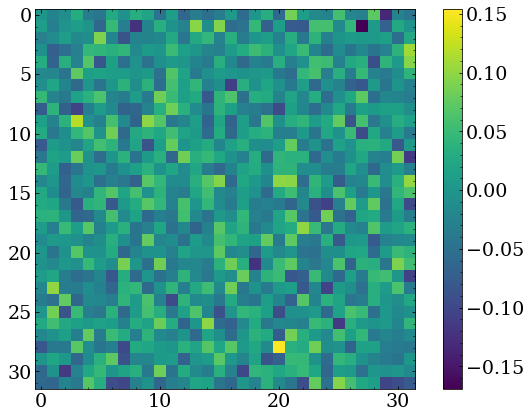

layer -4 neuron 27


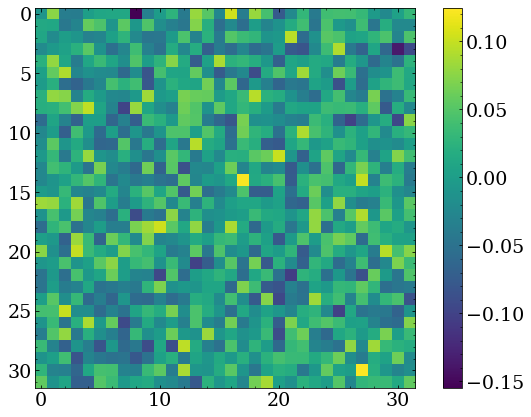

layer -4 neuron 28


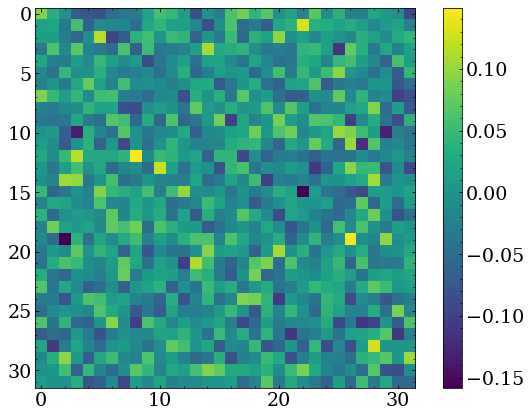

layer -4 neuron 29


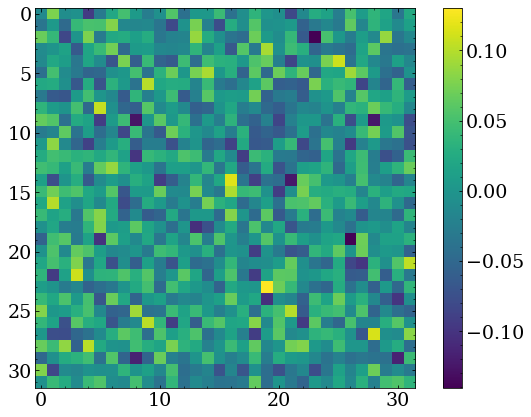

layer -4 neuron 30


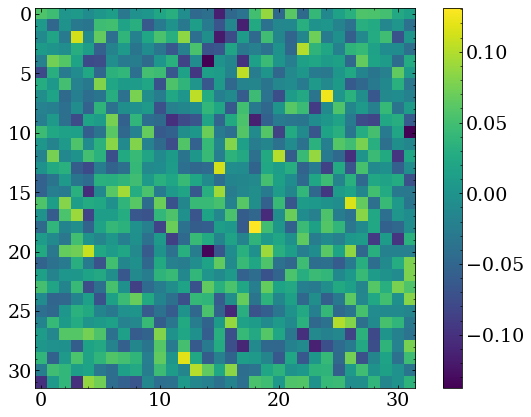

layer -4 neuron 31


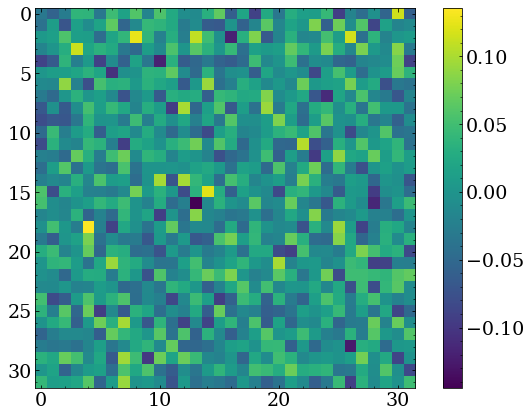

layer -4 neuron 32


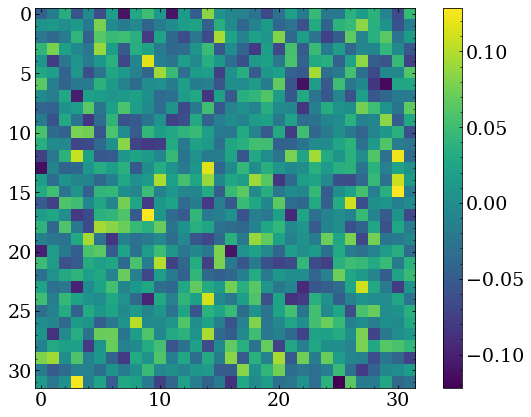

layer -4 neuron 33


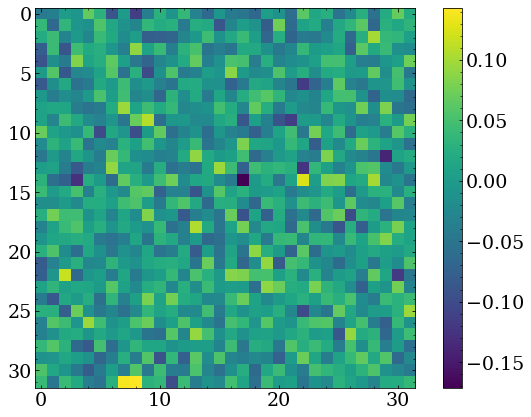

layer -4 neuron 34


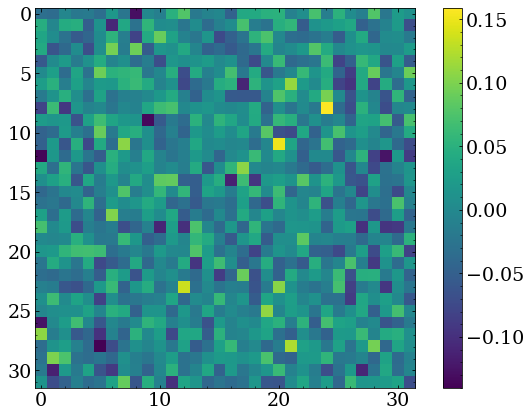

layer -4 neuron 35


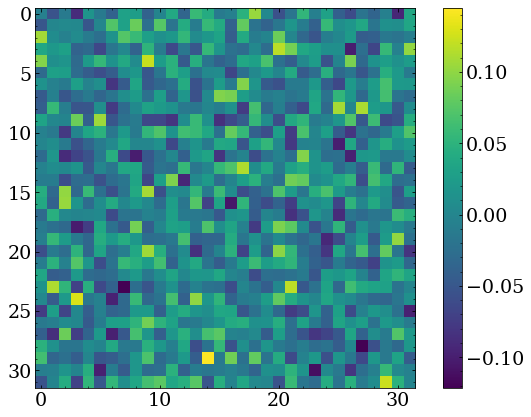

layer -4 neuron 36


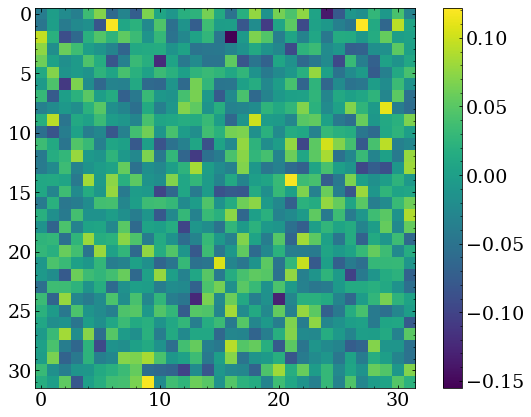

layer -4 neuron 37


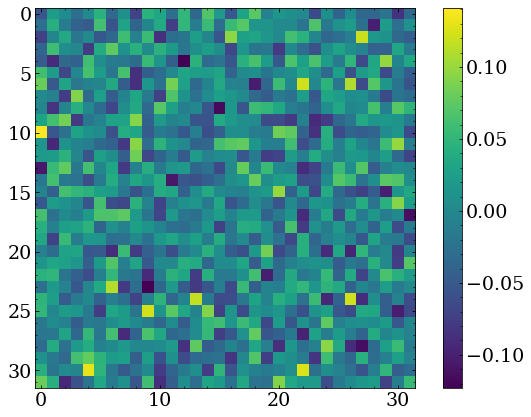

layer -4 neuron 38


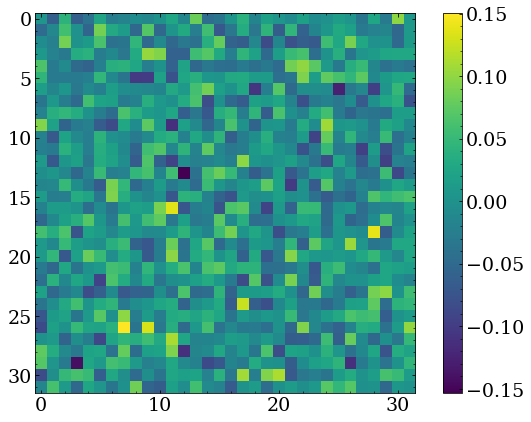

layer -4 neuron 39


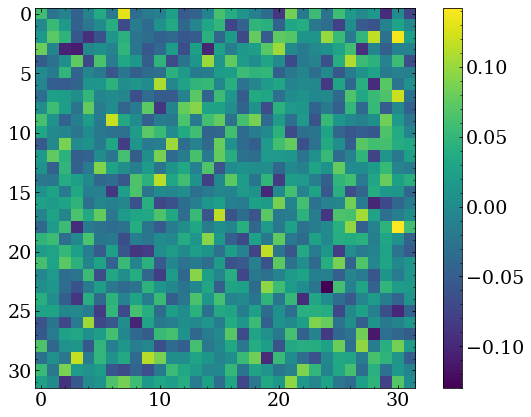

layer -4 neuron 40


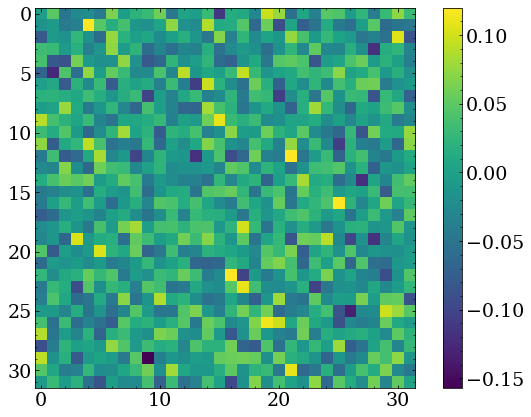

layer -4 neuron 41


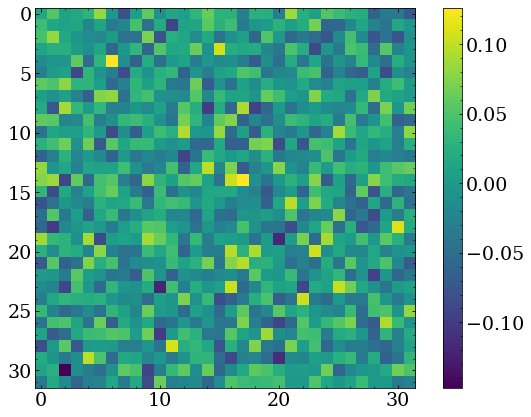

layer -4 neuron 42


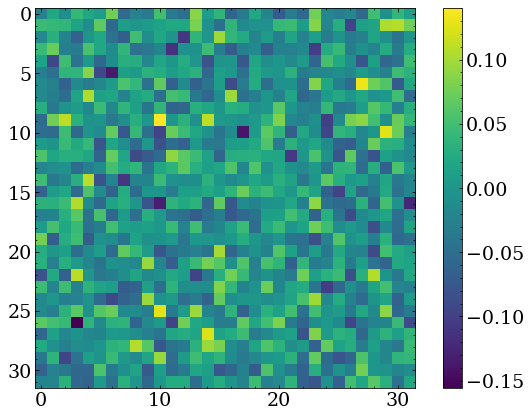

layer -4 neuron 43


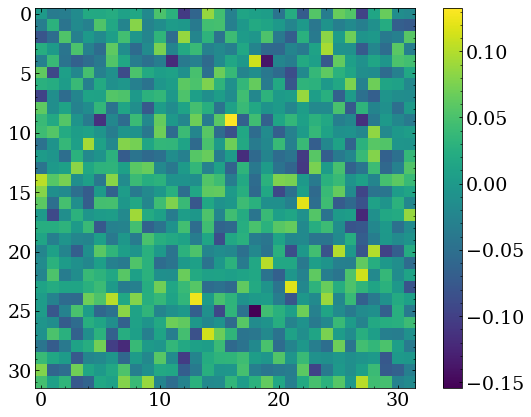

layer -4 neuron 44


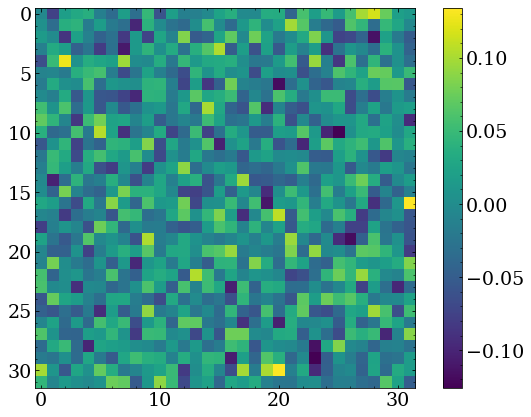

layer -4 neuron 45


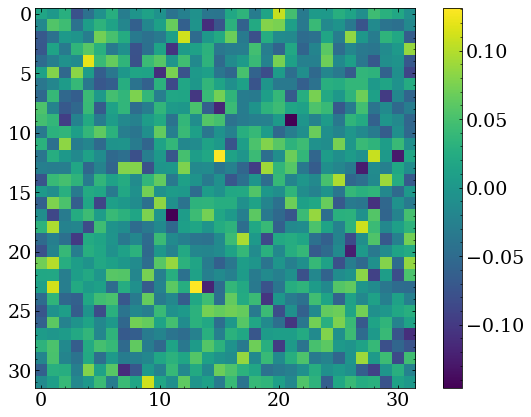

layer -4 neuron 46


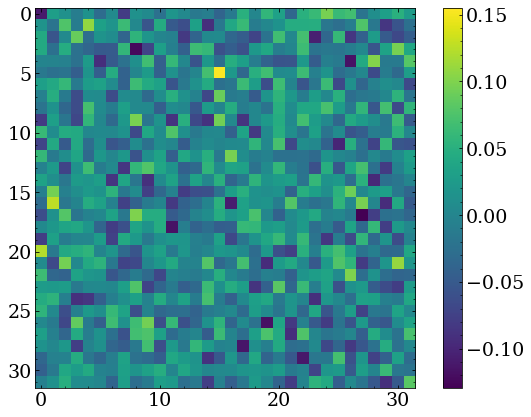

layer -4 neuron 47


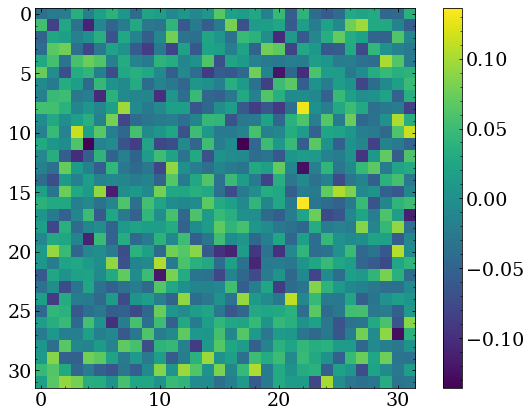

layer -4 neuron 48


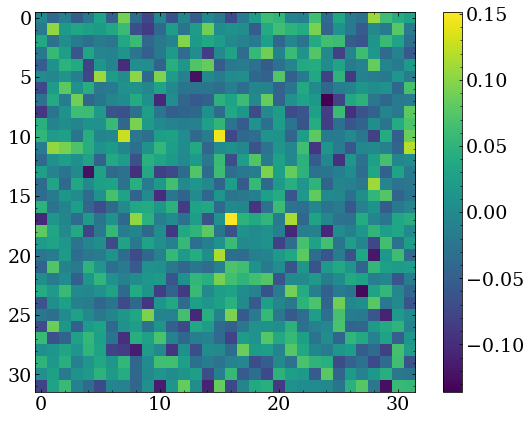

layer -4 neuron 49


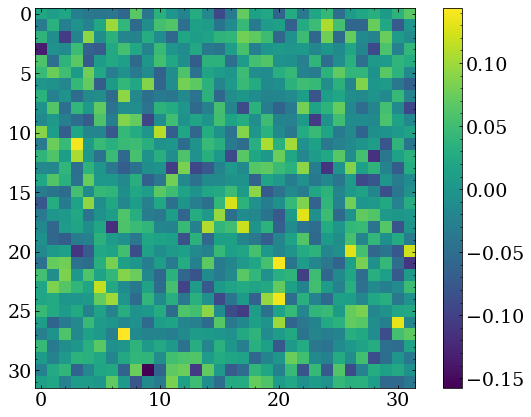

layer -4 neuron 50


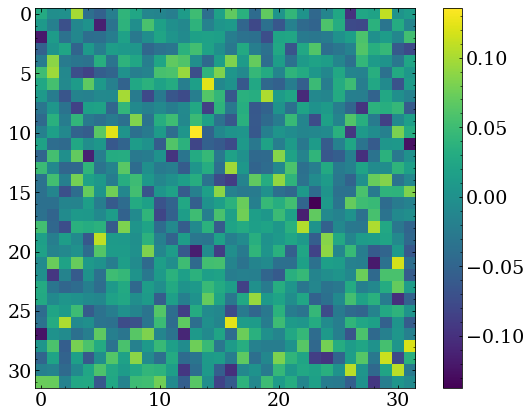

layer -4 neuron 51


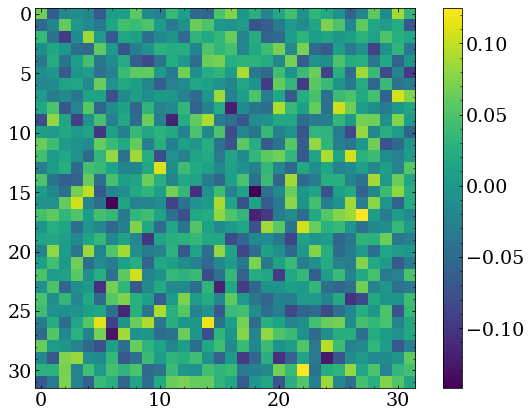

layer -4 neuron 52


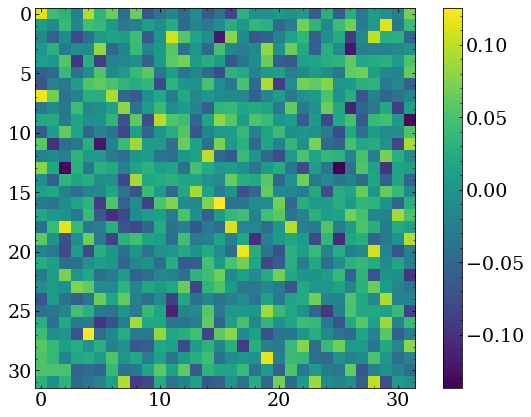

layer -4 neuron 53


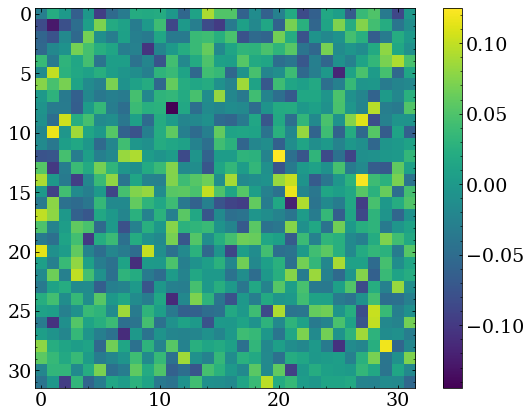

layer -4 neuron 54


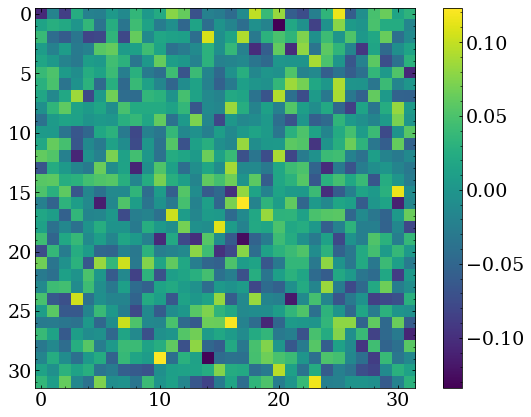

layer -4 neuron 55


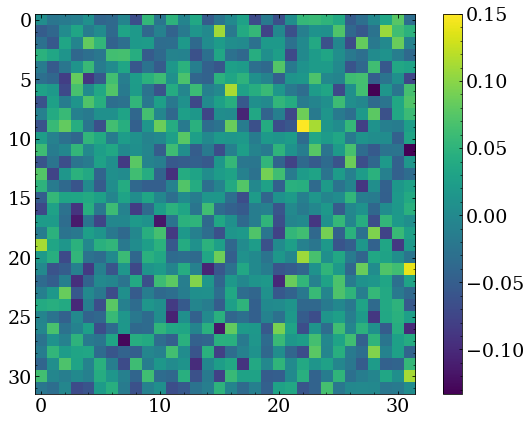

layer -4 neuron 56


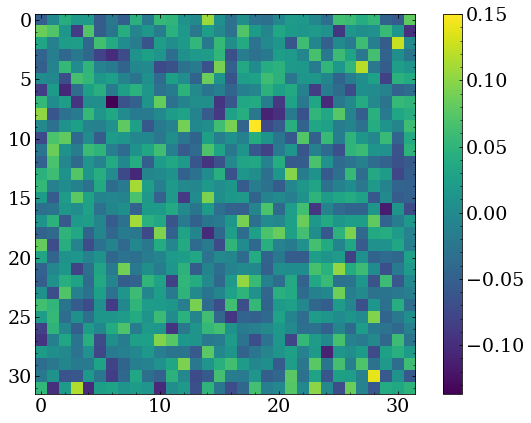

layer -4 neuron 57


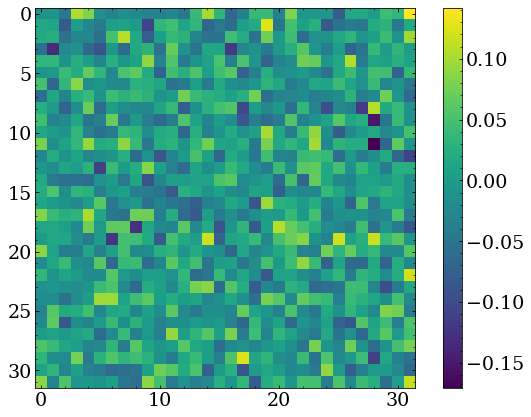

layer -4 neuron 58


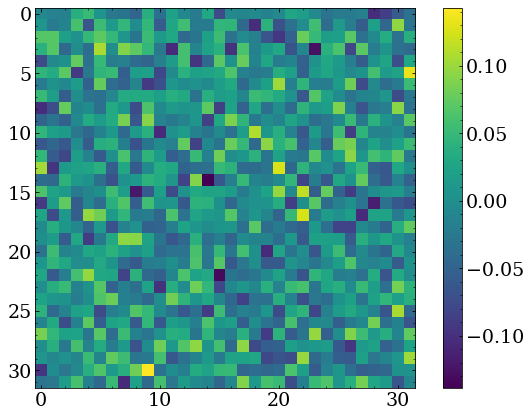

layer -4 neuron 59


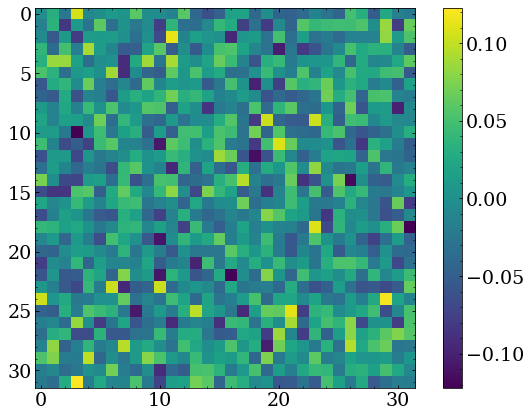

layer -4 neuron 60


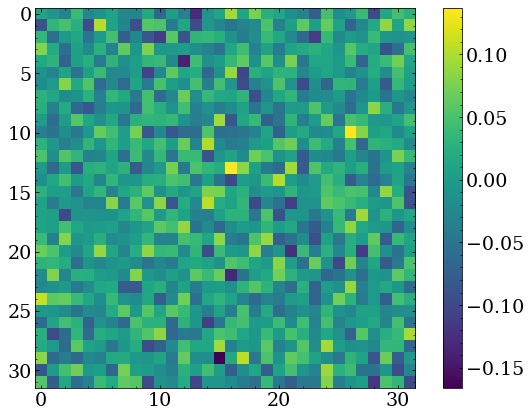

layer -4 neuron 61


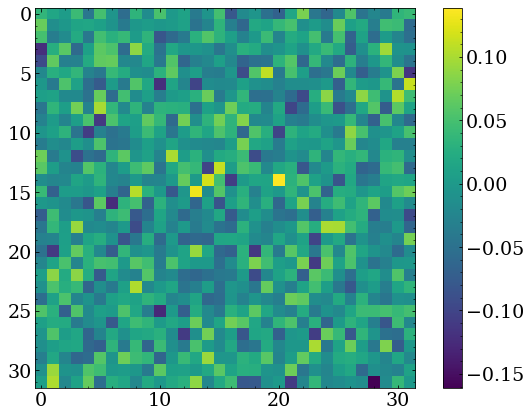

layer -4 neuron 62


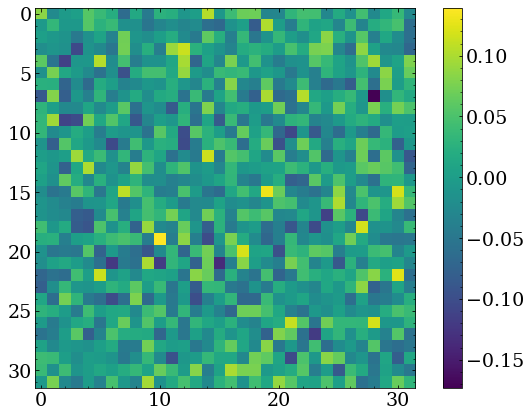

layer -4 neuron 63


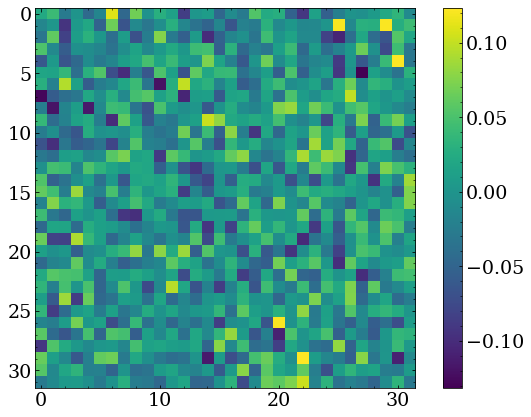

layer -4 neuron 64


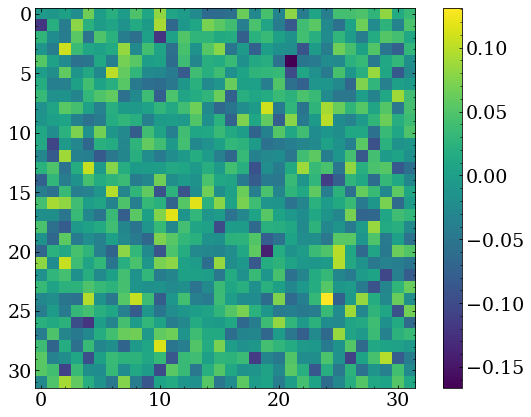

layer -4 neuron 65


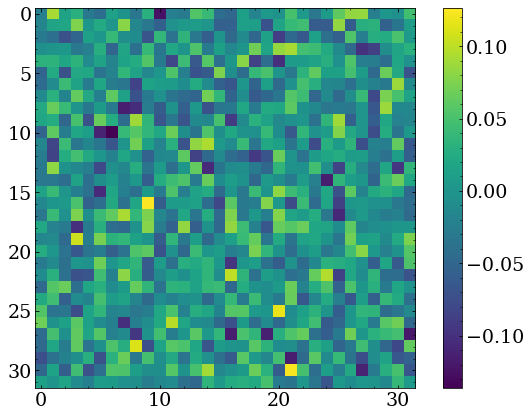

layer -4 neuron 66


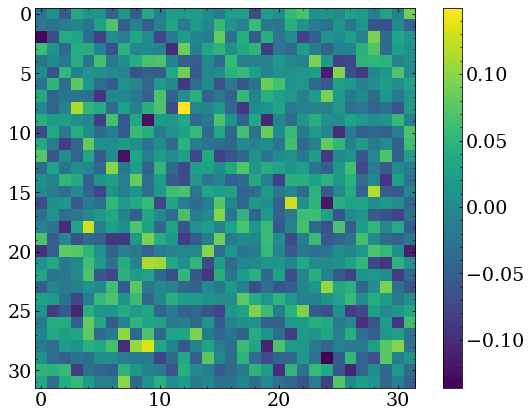

layer -4 neuron 67


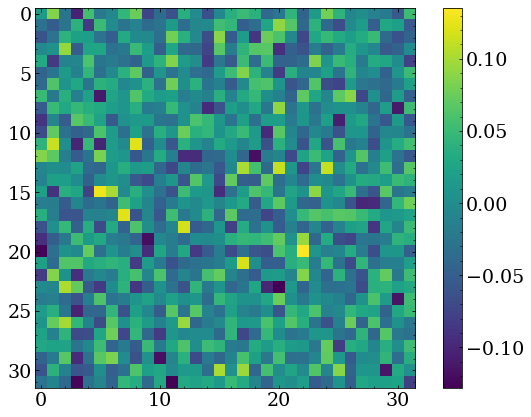

layer -4 neuron 68


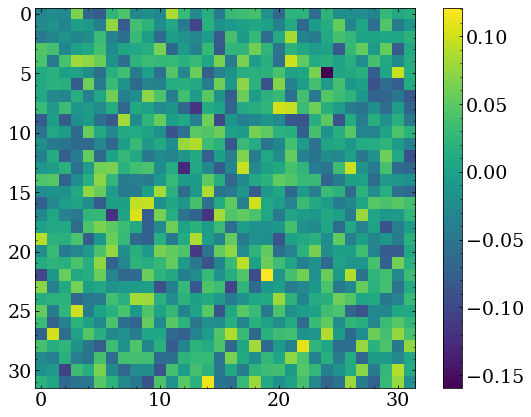

layer -4 neuron 69


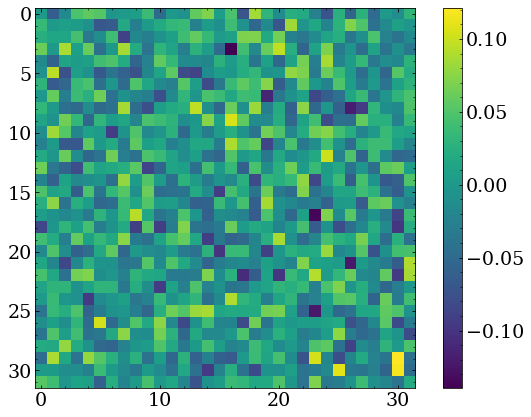

layer -4 neuron 70


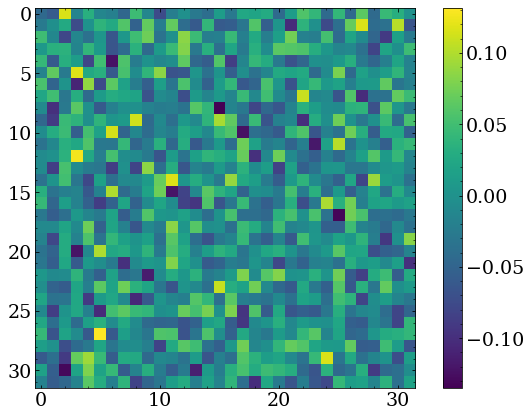

layer -4 neuron 71


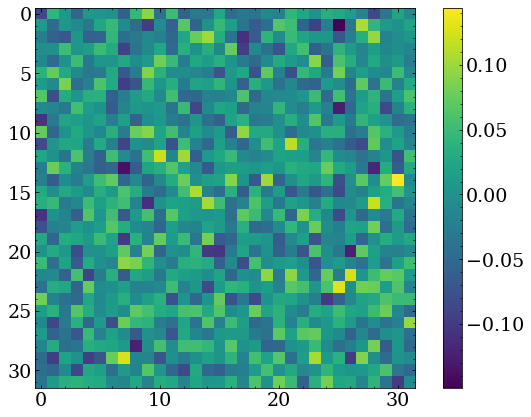

layer -4 neuron 72


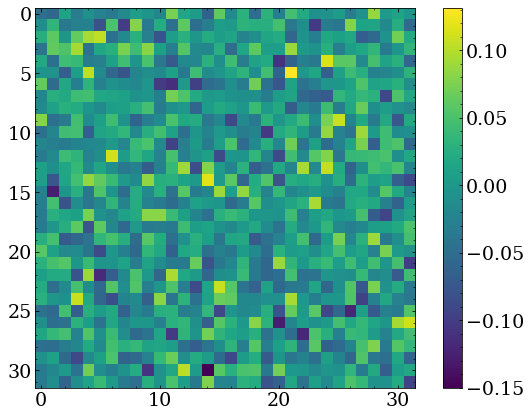

layer -4 neuron 73


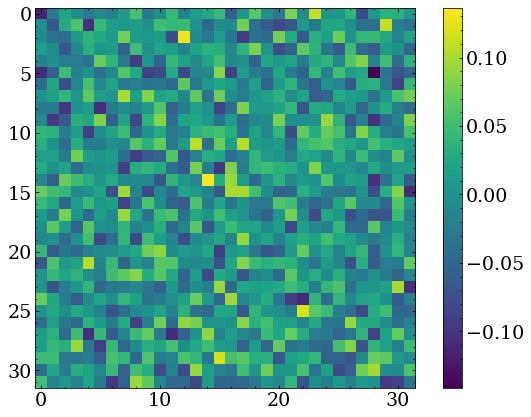

layer -4 neuron 74


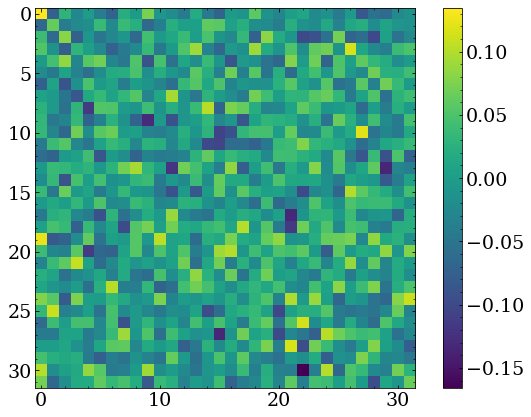

layer -4 neuron 75


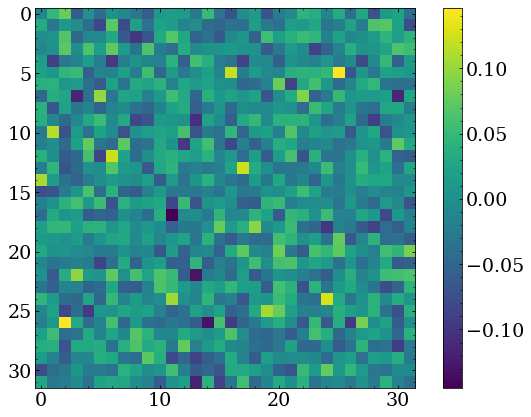

layer -4 neuron 76


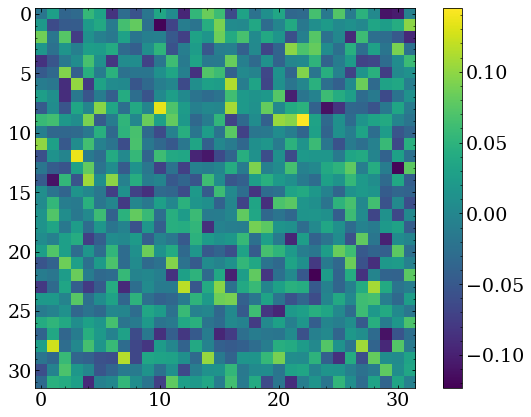

layer -4 neuron 77


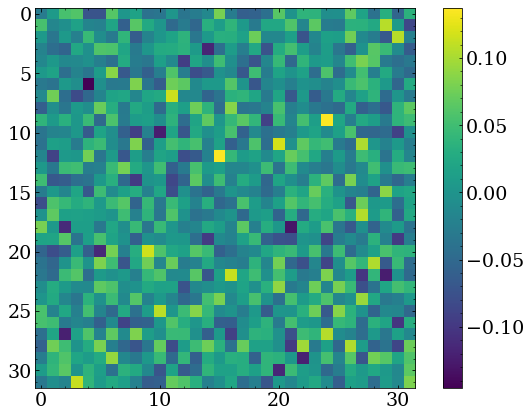

layer -4 neuron 78


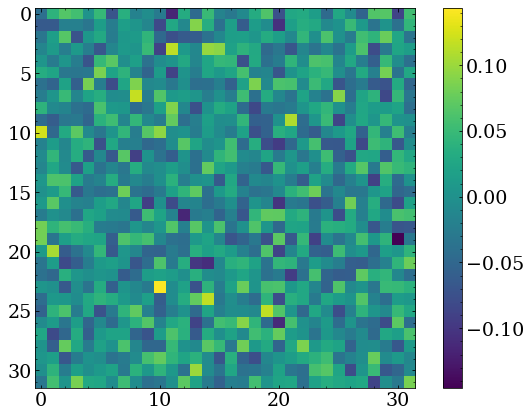

layer -4 neuron 79


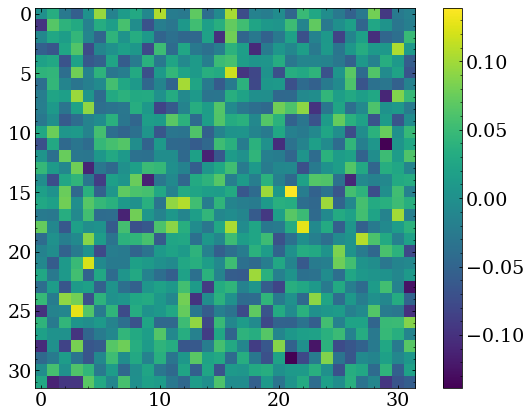

layer -4 neuron 80


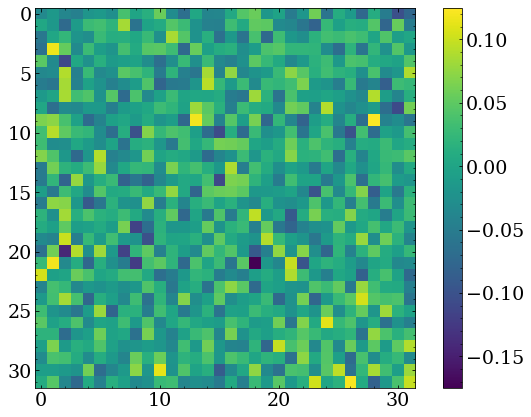

layer -4 neuron 81


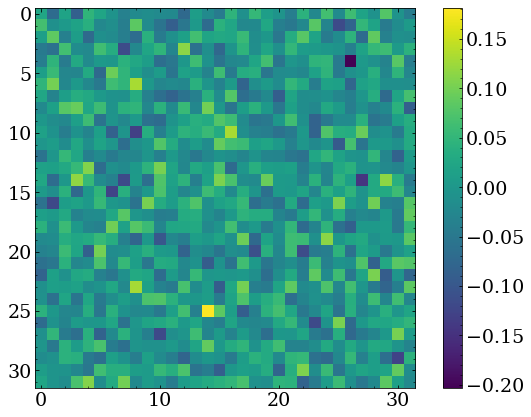

layer -4 neuron 82


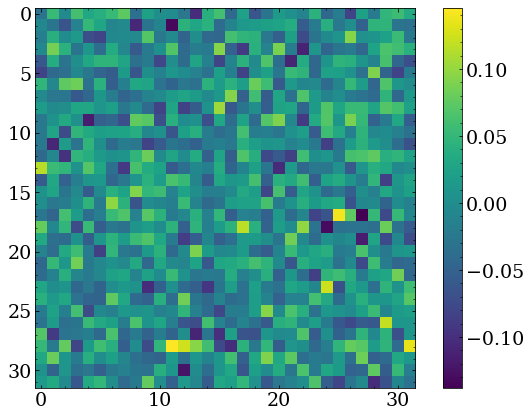

layer -4 neuron 83


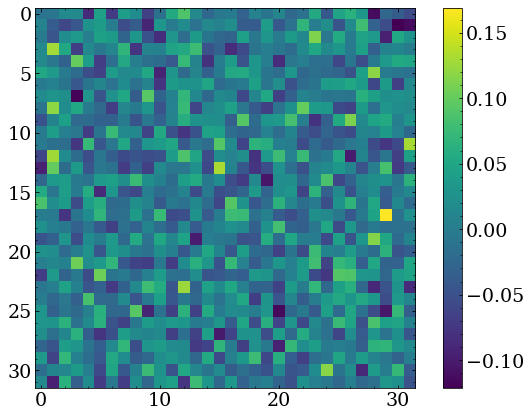

layer -4 neuron 84


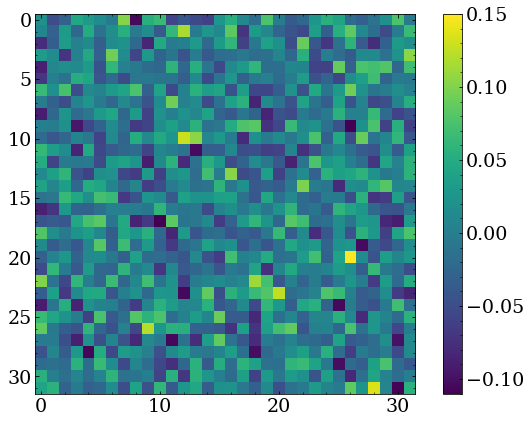

layer -4 neuron 85


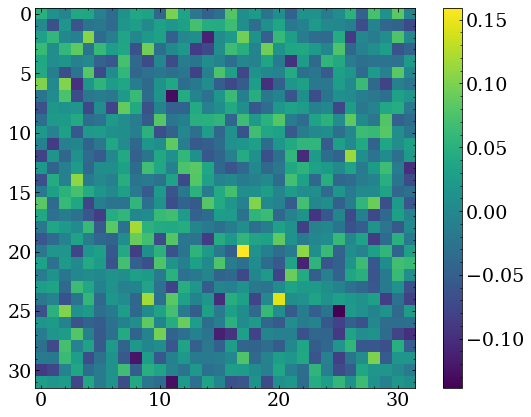

layer -4 neuron 86


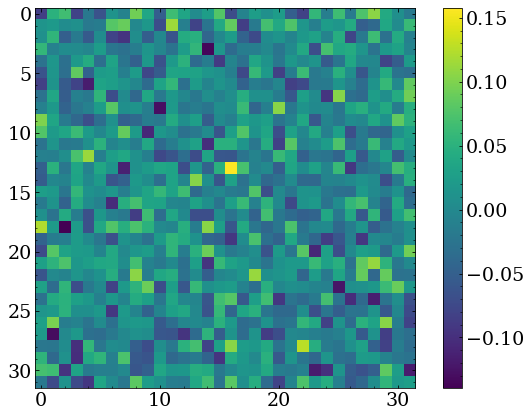

layer -4 neuron 87


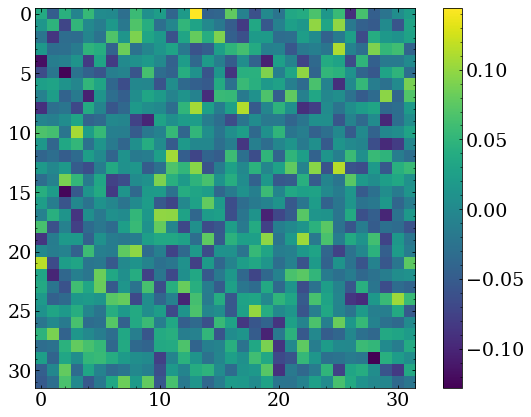

layer -4 neuron 88


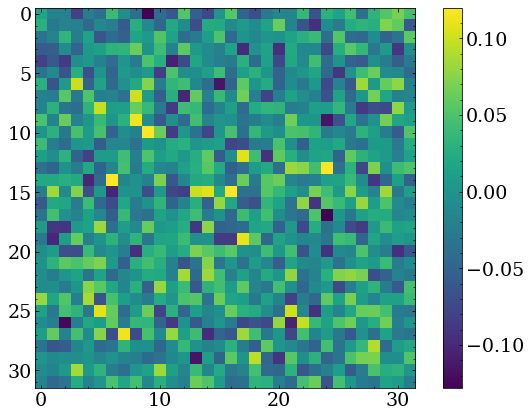

layer -4 neuron 89


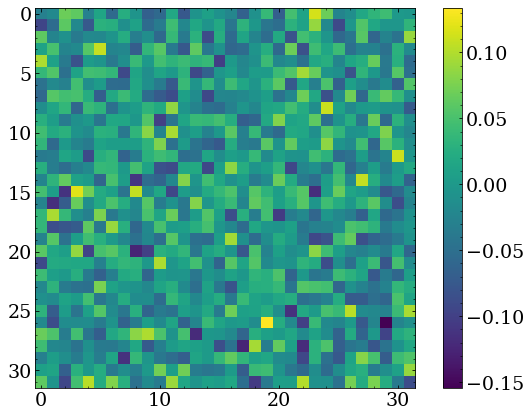

layer -4 neuron 90


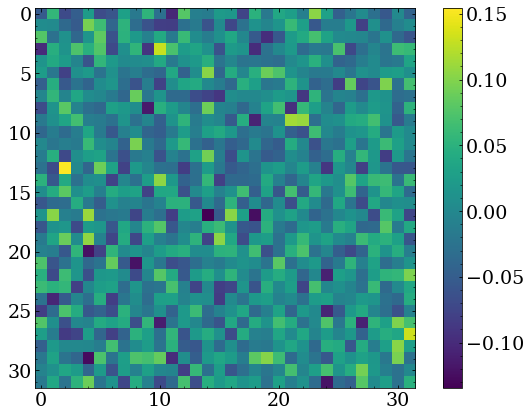

layer -4 neuron 91


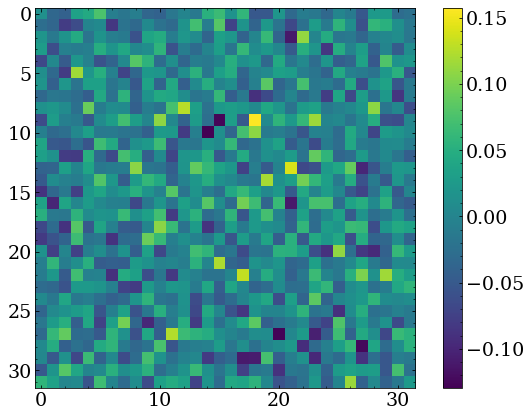

layer -4 neuron 92


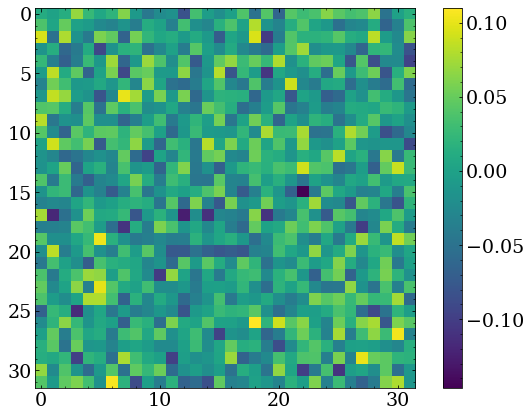

layer -4 neuron 93


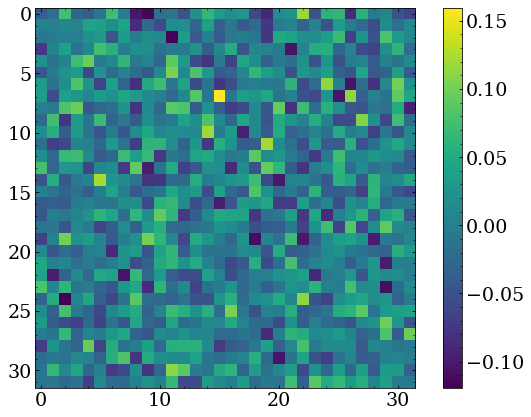

layer -4 neuron 94


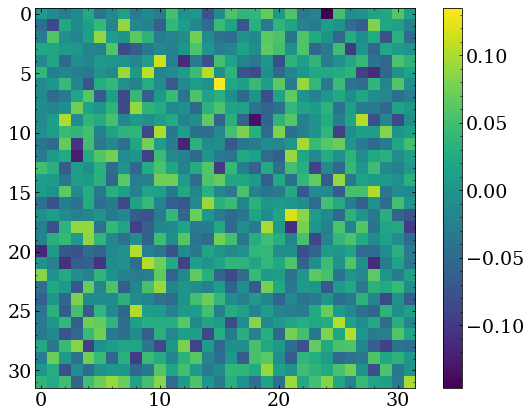

layer -4 neuron 95


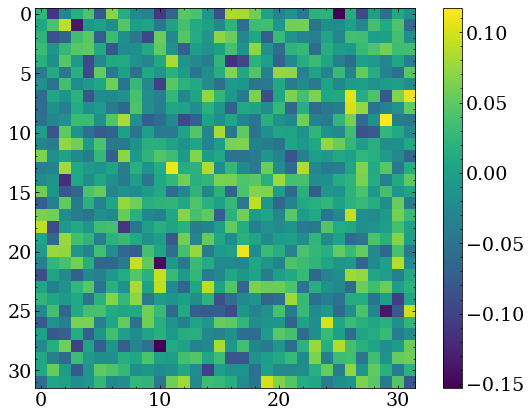

layer -4 neuron 96


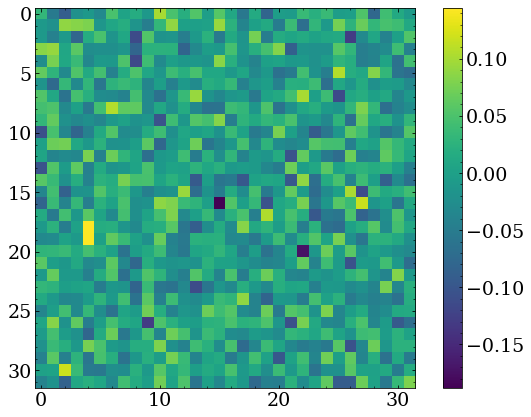

layer -4 neuron 97


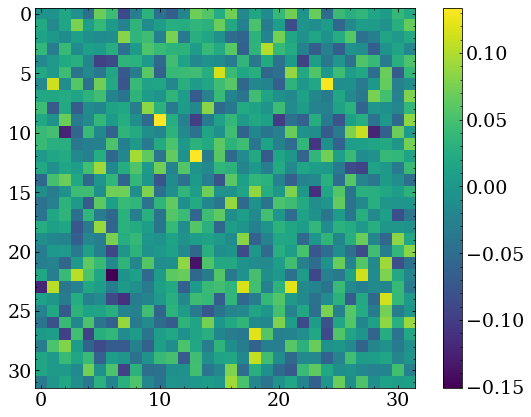

layer -4 neuron 98


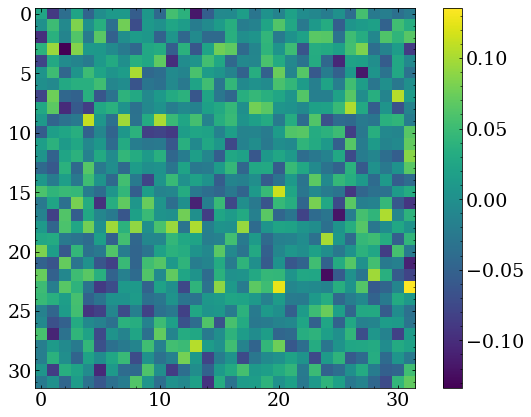

layer -4 neuron 99


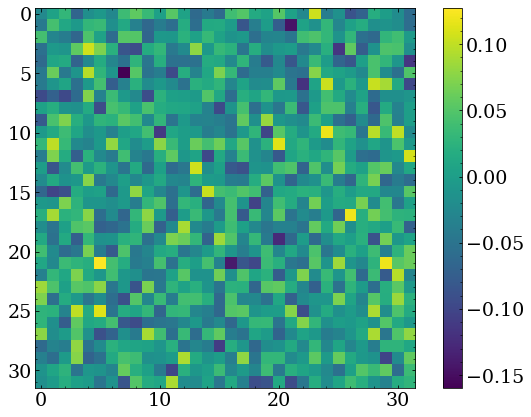

In [10]:
print(s.parts[-4])
for i in range(np.prod(hidden_shapes[0])):
    print('layer -4 neuron',i)
    plt.imshow(s.parts[-4].layer[0].weights[i,:].reshape((32,32)))
    plt.colorbar()
    plt.show()
    plt.close()